<a href="https://colab.research.google.com/github/bnsreenu/python_for_microscopists/blob/master/311_fine_tuning_GPT2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://youtu.be/nsdCRVuprDY

In [ ]:
!pip install transformers
!pip install -U PyPDF2
!pip install python-docx

In [4]:
import pandas as pd
import numpy as np
import re
from PyPDF2 import PdfReader
import os
# import docx

In [7]:
# Functions to read different file types
def read_pdf(file_path):
    with open(file_path, "rb") as file:
        pdf_reader = PdfReader(file)
        text = ""
        for page_num in range(len(pdf_reader.pages)):
            text += pdf_reader.pages[page_num].extract_text()
    return text

def read_word(file_path):
    doc = docx.Document(file_path)
    text = ""
    for paragraph in doc.paragraphs:
        text += paragraph.text + "\n"
    return text

def read_txt(file_path):
    with open(file_path, "r") as file:
        text = file.read()
    return text

def read_documents_from_directory(directory):
    combined_text = ""
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        if filename.endswith(".pdf"):
            combined_text += read_pdf(file_path)
        elif filename.endswith(".docx"):
            combined_text += read_word(file_path)
        elif filename.endswith(".txt"):
            combined_text += read_txt(file_path)
    return combined_text


In [9]:
# Read documents from the directory
#train_directory = '/content/drive/MyDrive/ColabNotebooks/data/chatbot_docs/training_data/full_text'
train_directory = 'assets/knowledge/training_questions'
text_data = read_txt(f'{train_directory}.txt')
text_data = re.sub(r'\n+', '\n', text_data).strip()  # Remove excess newline characters

In [10]:
#text_data = read_pdf('/content/drive/MyDrive/ColabNotebooks/data/chatbot_docs/Cell_Biology.pdf')
#text_data = re.sub(r'\n+', '\n', text_data).strip()  # Remove excess newline characters

In [11]:
# Save the training and validation data as text files
#with open("/content/drive/MyDrive/ColabNotebooks/data/chatbot_docs/combined_text/full_text/train.txt", "w") as f:
 #   f.write(text_data)

In [13]:
with open(f'{train_directory}_formatted.txt', "w") as f:
    f.write(text_data)

In [14]:
from transformers import TextDataset, DataCollatorForLanguageModeling
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from transformers import Trainer, TrainingArguments

In [15]:
def load_dataset(file_path, tokenizer, block_size = 128):
    dataset = TextDataset(
        tokenizer = tokenizer,
        file_path = file_path,
        block_size = block_size,
    )
    return dataset

In [16]:
def load_data_collator(tokenizer, mlm = False):
    data_collator = DataCollatorForLanguageModeling(
        tokenizer=tokenizer, 
        mlm=mlm,
    )
    return data_collator

In [17]:
def train(train_file_path,model_name,
          output_dir,
          overwrite_output_dir,
          per_device_train_batch_size,
          num_train_epochs,
          save_steps):
  tokenizer = GPT2Tokenizer.from_pretrained(model_name)
  train_dataset = load_dataset(train_file_path, tokenizer)
  data_collator = load_data_collator(tokenizer)

  tokenizer.save_pretrained(output_dir)
      
  model = GPT2LMHeadModel.from_pretrained(model_name)

  model.save_pretrained(output_dir)

  training_args = TrainingArguments(
          output_dir=output_dir,
          overwrite_output_dir=overwrite_output_dir,
          per_device_train_batch_size=per_device_train_batch_size,
          num_train_epochs=num_train_epochs,
      )

  trainer = Trainer(
          model=model,
          args=training_args,
          data_collator=data_collator,
          train_dataset=train_dataset,
  )
      
  trainer.train()
  trainer.save_model()

In [3]:

#train_file_path = "/content/drive/MyDrive/ColabNotebooks/data/chatbot_docs/combined_text/full_text/train.txt"
train_file_path = f"{train_directory}_formatted.txt"
model_name = 'gpt2'
#output_dir = '/content/drive/MyDrive/ColabNotebooks/models/chat_models/custom_full_text'
output_dir = 'assets/knowledge/custom_q_and_a'
overwrite_output_dir = False
per_device_train_batch_size = 8
num_train_epochs = 50.0
save_steps = 50000

NameError: name 'train_directory' is not defined

In [ ]:
# Train
train(
    train_file_path=train_file_path,
    model_name=model_name,
    output_dir=output_dir,
    overwrite_output_dir=overwrite_output_dir,
    per_device_train_batch_size=per_device_train_batch_size,
    num_train_epochs=num_train_epochs,
    save_steps=save_steps
)

C:\Users\point\anaconda3\lib\site-packages\transformers\data\datasets\language_modeling.py:54: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py
  warnings.warn(
C:\Users\point\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 19
  Num Epochs = 50
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 150
  Number of trainable parameters = 124439808

Step,Training Loss


Inference

In [ ]:
from transformers import PreTrainedTokenizerFast, GPT2LMHeadModel, GPT2TokenizerFast, GPT2Tokenizer

In [ ]:
def load_model(model_path):
    model = GPT2LMHeadModel.from_pretrained(model_path)
    return model


def load_tokenizer(tokenizer_path):
    tokenizer = GPT2Tokenizer.from_pretrained(tokenizer_path)
    return tokenizer

def generate_text(model_path, sequence, max_length):
    
    model = load_model(model_path)
    tokenizer = load_tokenizer(model_path)
    ids = tokenizer.encode(f'{sequence}', return_tensors='pt')
    final_outputs = model.generate(
        ids,
        do_sample=True,
        max_length=max_length,
        pad_token_id=model.config.eos_token_id,
        top_k=50,
        top_p=0.95,
    )
    print(tokenizer.decode(final_outputs[0], skip_special_tokens=True))

This model got trained on the entire text and took much longer to train, and yet it fails to give meaningful results. 

In [ ]:
model1_path = "/content/drive/MyDrive/ColabNotebooks/models/chat_models/custom_full_text"
sequence1 = "[Q] What is the Babel fish?"
max_len = 50
generate_text(model1_path, sequence1, max_len) 

[Q] What is the Babel fish?  Theyve  never  heard  of  it  They  
make  fish  Theyve  gone  back  into  space


The following model was trained on 100 questions and answers based on the original text and it trained in a few seconds (50 epochs). It gives very meaningful results. 

In [ ]:
model2_path = "/content/drive/MyDrive/ColabNotebooks/models/chat_models/custom_q_and_a"
sequence2 = "[Q] What is the Babel fish?"
max_len = 50
generate_text(model2_path, sequence2, max_len) 

[Q] What is the Babel fish?
[A] The Babel fish is a small, yellow, leech-like creature that can be inserted into a person's ear to instantly translate any language into the user's native tongue.
[


In [9]:
from transformers import TextDataset, DataCollatorForLanguageModeling
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from transformers import Trainer, TrainingArguments

def load_dataset(file_path, tokenizer, block_size = 128):
    dataset = TextDataset(
        tokenizer = tokenizer,
        file_path = file_path,
        block_size = block_size,
    )
    return dataset

def load_data_collator(tokenizer, mlm = False):
    data_collator = DataCollatorForLanguageModeling(
        tokenizer=tokenizer,
        mlm=mlm,
    )
    return data_collator

#train_file_path = "/content/drive/MyDrive/ColabNotebooks/data/chatbot_docs/combined_text/full_text/train.txt"
train_directory = 'assets/knowledge/pdf_textbook' # training_questions
train_file_path = f"{train_directory}.txt"
model_name = 'gpt2'
#output_dir = '/content/drive/MyDrive/ColabNotebooks/models/chat_models/custom_full_text'
output_dir = 'assets/knowledge/custom_q_and_a'
overwrite_output_dir = False
per_device_train_batch_size = 8
num_train_epochs = 50.0
save_steps = 50000



tokenizer = GPT2Tokenizer.from_pretrained(model_name)
train_dataset = load_dataset(train_file_path, tokenizer)
data_collator = load_data_collator(tokenizer)

In [11]:
dir(train_dataset)

['__add__',
 '__class__',
 '__class_getitem__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__orig_bases__',
 '__parameters__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_is_protocol',
 'examples']

In [23]:
from datasets import load_dataset

print('Getting data')
dataset = load_dataset("natural_questions", "dev")
print('Finished getting data!')

Getting data


Downloading:   0%|          | 0.00/4.62k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.45G [00:00<?, ?B/s]

ModuleNotFoundError: No module named 'apache_beam'

{'annotations': [{'annotation_id': 13591449469826568799, 'long_answer': {'candidate_index': 92, 'end_byte': 67824, 'end_token': 925, 'start_byte': 66429, 'start_token': 808}, 'short_answers': [{'end_byte': 66817, 'end_token': 837, 'start_byte': 66588, 'start_token': 816}], 'yes_no_answer': 'NONE'}, {'annotation_id': 6237931520544082939, 'long_answer': {'candidate_index': 92, 'end_byte': 67824, 'end_token': 925, 'start_byte': 66429, 'start_token': 808}, 'short_answers': [{'end_byte': 66609, 'end_token': 819, 'start_byte': 66588, 'start_token': 816}], 'yes_no_answer': 'NONE'}, {'annotation_id': 12127791536449879527, 'long_answer': {'candidate_index': 92, 'end_byte': 67824, 'end_token': 925, 'start_byte': 66429, 'start_token': 808}, 'short_answers': [], 'yes_no_answer': 'NONE'}, {'annotation_id': 6421980561691125452, 'long_answer': {'candidate_index': 92, 'end_byte': 67824, 'end_token': 925, 'start_byte': 66429, 'start_token': 808}, 'short_answers': [{'end_byte': 66817, 'end_token': 837, 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



{'annotations': [{'annotation_id': 10385324122607597105, 'long_answer': {'candidate_index': 3, 'end_byte': 75512, 'end_token': 1790, 'start_byte': 43393, 'start_token': 128}, 'short_answers': [{'end_byte': 57940, 'end_token': 881, 'start_byte': 57929, 'start_token': 879}], 'yes_no_answer': 'NONE'}, {'annotation_id': 6952755084274283189, 'long_answer': {'candidate_index': 3, 'end_byte': 75512, 'end_token': 1790, 'start_byte': 43393, 'start_token': 128}, 'short_answers': [{'end_byte': 57940, 'end_token': 881, 'start_byte': 57929, 'start_token': 879}, {'end_byte': 58076, 'end_token': 887, 'start_byte': 58062, 'start_token': 885}, {'end_byte': 58215, 'end_token': 893, 'start_byte': 58200, 'start_token': 891}], 'yes_no_answer': 'NONE'}, {'annotation_id': 8976137912835443163, 'long_answer': {'candidate_index': 3, 'end_byte': 75512, 'end_token': 1790, 'start_byte': 43393, 'start_token': 128}, 'short_answers': [{'end_byte': 57940, 'end_token': 881, 'start_byte': 57929, 'start_token': 879}], 'y
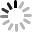

In [4]:
import jsonlines
with jsonlines.open('C:\\Users\\point\\Downloads\\v1.0-simplified_nq-dev-all\\v1.0-simplified_nq-dev-all.jsonl') as f:
    i = 0
    for line in f.iter():
        if i <100:
            print(line)
            i+=1
        else:
            break

In [1]:
import pandas as pd
jsonObj = pd.read_json(path_or_buf='C:\\Users\\point\\Downloads\\v1.0-simplified_nq-dev-all\\v1.0-simplified_nq-dev-all.jsonl', lines=True)

MemoryError: 

In [3]:
import json

input_file = "C:\\Users\\point\\Downloads\\v1.0-simplified_nq-dev-all\\v1.0-simplified_nq-dev-all.jsonl"
output_file = "C:\\Users\\point\\Downloads\\v1.0-simplified_nq-dev-all\\SMALL_v1.0-simplified_nq-dev-all.jsonl"

lines_to_keep = 100
lines_kept = 0

with open(input_file, "r", encoding="utf-8") as input_fp, open(output_file, "w", encoding="utf-8") as output_fp:
    for line in input_fp:
        if lines_kept >= lines_to_keep:
            break

        # Process each line as a JSON object
        data = json.loads(line)

        # Write the line to the output file
        output_fp.write(json.dumps(data) + "\n")

        lines_kept += 1

In [4]:
import pandas as pd
jsonObj = pd.read_json(path_or_buf='C:\\Users\\point\\Downloads\\v1.0-simplified_nq-dev-all\\SMALL_v1.0-simplified_nq-dev-all.jsonl', lines=True)

In [8]:
jsonObj

In [6]:
# 1st document in text form
wiki_doc = [i['token'] for i in jsonObj['document_tokens'][0]]
print(''.join(wiki_doc))

Thereforesign-wikipedia<H1>Thereforesign</H1>Jumpto:navigation,search<Table><Tr><Th colspan="2">∴</Th></Tr><Tr><Td colspan="2">Thereforesign</Td></Tr><Tr><Td colspan="2"><Table><Tr><Th colspan="2">Punctuation</Th></Tr><Tr><Td>apostrophe</Td><Td>''</Td></Tr><Tr><Td>brackets</Td><Td>()()()⟨⟩</Td></Tr><Tr><Td>colon</Td><Td>:</Td></Tr><Tr><Td>comma</Td><Td>,،、</Td></Tr><Tr><Td>dash</Td><Td>‒----―</Td></Tr><Tr><Td>ellipsis</Td><Td>......⋯᠁ฯ</Td></Tr><Tr><Td>exclamationmark</Td><Td>!</Td></Tr><Tr><Td>fullstop,period</Td><Td>.</Td></Tr><Tr><Td>guillemets</Td><Td>``''``''</Td></Tr><Tr><Td>hyphen</Td><Td>‐</Td></Tr><Tr><Td>hyphen-minus</Td><Td>-</Td></Tr><Tr><Td>questionmark</Td><Td>?</Td></Tr><Tr><Td>quotationmarks</Td><Td>''``''''``''</Td></Tr><Tr><Td>semicolon</Td><Td>;</Td></Tr><Tr><Td>slash,stroke,solidus</Td><Td>/⁄</Td></Tr></Table></Td></Tr><Tr><Td colspan="2"><Table><Tr><Th colspan="2">Worddividers</Th></Tr><Tr><Td>interpunct</Td><Td></Td></Tr><Tr><Td>space</Td><Td></Td></Tr></Table></T

In [8]:
# 1 Answer
wiki_answer = jsonObj['annotations'][0][0]['long_answer']
' '.join(wiki_doc[wiki_answer['start_token']:wiki_answer['end_token']])

KeyboardInterrupt: 